# 02 — Graph Construction (Bipartite CV–Job)

## Objectif
Construire le graphe biparti **CV–Job** à partir des données prétraitées (`data/processed/`).

Le graphe contient :
- Nœuds de type **CV** avec attributs (texte nettoyé, niveau, domaine…)
- Nœuds de type **Job** avec attributs (texte nettoyé, niveau requis, domaine…)
- Arêtes **CV ↔ Job** issues des matches connus

## Sorties
- Un objet NetworkX `G`
- Vérifications bipartites
- Une visualisation (sous-graphe)
- Sauvegarde du graphe (GraphML)

In [ ]:
import os
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)

In [2]:
PROC_DIR = "data/processed"
RESULTS_DIR = "results"

CV_PATH = os.path.join(PROC_DIR, "cv_clean.csv")
JOB_PATH = os.path.join(PROC_DIR, "job_clean.csv")
EDGES_PATH = os.path.join(PROC_DIR, "edges.csv")

os.makedirs(RESULTS_DIR, exist_ok=True)

cv = pd.read_csv(CV_PATH)
job = pd.read_csv(JOB_PATH)
edges = pd.read_csv(EDGES_PATH)

print("cv:", cv.shape)
print("job:", job.shape)
print("edges:", edges.shape)

cv.head(3)

cv: (300, 6)
job: (90, 5)
edges: (1200, 2)


,cv_id,clean_text,level,profile_type,domain,skills_norm_str
0,CV_0000,cv profile junior candidate in design experien...,junior,polyvalent,design,"linux, javascript, scrum, git, python, budgeti..."
1,CV_0001,cv profile intermediate candidate in design ex...,intermediate,specialized,design,"typography, design systems, adobe photoshop, u..."
2,CV_0002,cv profile junior candidate in management expe...,junior,specialized,management,"agile, scrum, budgeting, communication, planni..."


## 2) Construction du graphe biparti

On crée un graphe non-orienté `G` :

- Pour chaque CV : on ajoute un nœud `cv_id` avec attributs + `node_type="cv"`
- Pour chaque Job : on ajoute un nœud `job_id` avec attributs + `node_type="job"`
- Pour chaque match : on ajoute une arête `(cv_id, job_id)` avec `edge_type="match"`

In [3]:
G = nx.Graph()

# 1) Add CV nodes
for _, r in cv.iterrows():
    attrs = r.to_dict()
    node_id = attrs.pop("cv_id")
    attrs["node_type"] = "cv"
    G.add_node(node_id, **attrs)

# 2) Add Job nodes
for _, r in job.iterrows():
    attrs = r.to_dict()
    node_id = attrs.pop("job_id")
    attrs["node_type"] = "job"
    G.add_node(node_id, **attrs)

# 3) Add edges
for _, r in edges.iterrows():
    G.add_edge(r["cv_id"], r["job_id"], edge_type="match")

print("✅ Graph built")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

✅ Graph built
Nodes: 390
Edges: 1200


## 3) Vérifications (sanity checks)

On vérifie :
- séparation CV / Job
- absence d’arêtes CV–CV et Job–Job
- exemple de degrés

In [4]:
cv_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "cv"]
job_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "job"]

print("CV nodes:", len(cv_nodes))
print("Job nodes:", len(job_nodes))

# Check for invalid edges (should not exist in bipartite)
bad_cv_cv = [(u, v) for u, v in G.edges() if u in cv_nodes and v in cv_nodes]
bad_job_job = [(u, v) for u, v in G.edges() if u in job_nodes and v in job_nodes]

print("CV-CV edges:", len(bad_cv_cv))
print("Job-Job edges:", len(bad_job_job))

# Degree examples
print("Degree example CV:", cv_nodes[0], G.degree(cv_nodes[0]))
print("Degree example Job:", job_nodes[0], G.degree(job_nodes[0]))

CV nodes: 300
Job nodes: 90
CV-CV edges: 0
Job-Job edges: 0
Degree example CV: CV_0000 4
Degree example Job: JOB_0000 16


## 4) Visualisation (sous-graphe)

Un graphe biparti complet peut être trop grand pour être visualisé.
On extrait un sous-ensemble de CV et leurs Jobs connectés, puis on le dessine.

Subgraph nodes: 87 edges: 100


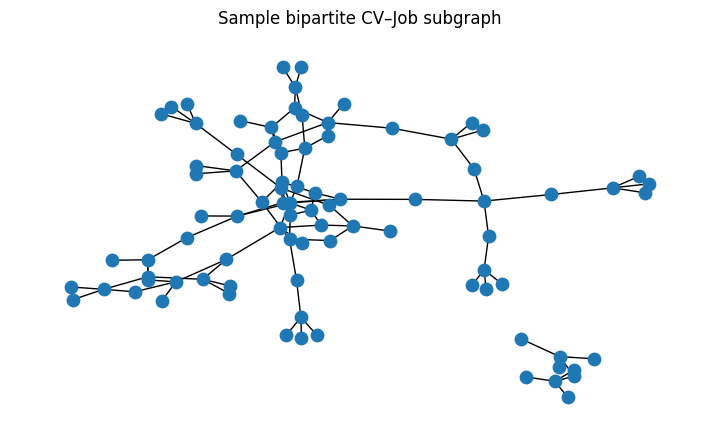

In [5]:
import random

random.seed(42)

# sample a subset of CV nodes
sample_cvs = random.sample(cv_nodes, k=min(25, len(cv_nodes)))

# include all their neighboring jobs
neighbors = set()
for c in sample_cvs:
    neighbors.update(G.neighbors(c))

H = G.subgraph(sample_cvs + list(neighbors)).copy()

print("Subgraph nodes:", H.number_of_nodes(), "edges:", H.number_of_edges())

pos = nx.spring_layout(H, seed=42)

plt.figure()
nx.draw(H, pos, with_labels=False, node_size=80)
plt.title("Sample bipartite CV–Job subgraph")
plt.show()

In [ ]:
from networkx.algorithms import bipartite

# On réutilise le sous-graphe H construit ci-dessus
cv_H = [n for n, d in H.nodes(data=True) if d.get("node_type") == "cv"]
job_H = [n for n, d in H.nodes(data=True) if d.get("node_type") == "job"]

print(f"Subgraph CV nodes: {len(cv_H)}, Job nodes: {len(job_H)}")

# Layout biparti : CV en colonne de gauche, Jobs en colonne de droite
pos = {}
pos.update((n, (0, i)) for i, n in enumerate(cv_H))   # CV column
pos.update((n, (1, i)) for i, n in enumerate(job_H))  # Job column

plt.figure(figsize=(8, 6))
nx.draw(
    H,
    pos,
    with_labels=False,
    node_size=60,
    node_color=["tab:blue" if n in cv_H else "tab:orange" for n in H.nodes()],
    edge_color="lightgray",
    alpha=0.8,
)
plt.title("Bipartite CV–Job subgraph (CV = bleu, Jobs = orange)")
plt.axis("off")
plt.tight_layout()
plt.show()

## 5) Sauvegarde du graphe

On sauvegarde le graphe en **GraphML** pour le réutiliser dans les notebooks suivants.

In [7]:
graph_path = os.path.join(RESULTS_DIR, "graph_bipartite.graphml")
nx.write_graphml(G, graph_path)

print("Graph saved to:", graph_path)

Graph saved to: results/graph_bipartite.graphml


# Conclusion

Nous avons construit le graphe biparti CV–Job :
- nœuds CV et Jobs avec attributs
- arêtes = matches connus
- vérifications bipartites OK
- sauvegarde GraphML effectuée
